In [1]:
import pandas as pd
import pytz
import sklearn
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

In [16]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.load_local_data import load_data

In [14]:
path = os.getcwd()
print("Current Directory", path)
 

parent_directory = os.path.dirname(path)
print("Parent Directory", parent_directory)

data_directory = parent_directory + '\data'
print("Data Directory", data_directory)

Current Directory c:\Users\elmha\OneDrive - Universidad de Chile\GitHub\Sistema_Experto_APP\notebooks
Parent Directory c:\Users\elmha\OneDrive - Universidad de Chile\GitHub\Sistema_Experto_APP
Data Directory c:\Users\elmha\OneDrive - Universidad de Chile\GitHub\Sistema_Experto_APP\data


In [15]:
local_path = data_directory + '\Horcon-etiquetado_con_1_etiqueta.csv'
df = load_data(local_path)
df.head()

,Pression [cm H2O],Temperatura [°C],EC [µs/cm],etiqueta conjunta
Date_Time,,,,
2013-02-03 10:00:00-03:00,981.5,17.81,257,1
2013-02-03 11:00:00-03:00,871.1,17.86,9,1
2013-02-03 12:00:00-03:00,870.7,17.80,9,1
2013-02-03 13:00:00-03:00,1025.5,17.71,256,1
2013-02-03 14:00:00-03:00,870.3,17.84,9,1


In [5]:
y = df['etiqueta conjunta']
X = df.drop(labels='etiqueta conjunta',axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, y,shuffle=False, test_size=0.2, random_state=42)



# Funciones auxiliares

# Feature Engineering Test


Validando si features aportan https://towardsdatascience.com/top-4-time-series-feature-engineering-lessons-from-kaggle-ca2d4c9cbbe7

In [6]:

from sklearn.model_selection import TimeSeriesSplit, KFold

In [10]:
def show_cv_iterations(n_splits, X, y, timeseries=True):
    # https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4
    if timeseries:
        cv = TimeSeriesSplit(n_splits)
    else:
        cv = KFold(n_splits)
    
    fig, ax = plt.subplots(figsize=(10, 5))

    for ii, (tr, tt) in enumerate(cv.split(X, y)):
        
        p1 = ax.scatter(tr, [ii] * len(tr), c='black', marker="_", lw=8)
        p2 = ax.scatter(tt, [ii] * len(tt), c='red', marker="_", lw=8)
        ax.set(
            title="Behavior of TimeseriesSplit",
            xlabel="Data Index",
            ylabel="CV Iteration",
            ylim=[5, -1],
        )
        ax.legend([p1, p2], ["Training", "Validation"])

    plt.show()
    return(cv)

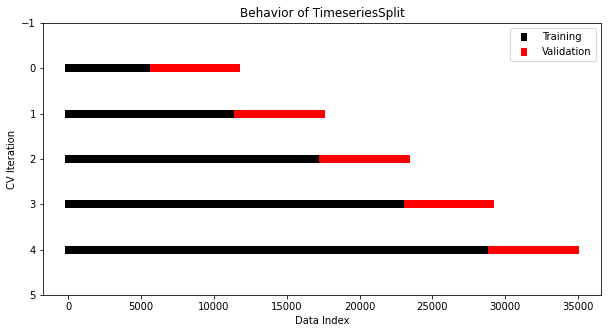

In [11]:
show_cv_iterations(5,X,y)

In [14]:
X.values

array([[ 981.5 ,   17.81,  257.  ],
       [ 871.1 ,   17.86,    9.  ],
       [ 870.7 ,   17.8 ,    9.  ],
       ...,
       [1034.2 ,   22.66,    0.  ],
       [1034.6 ,   22.51,    0.  ],
       [1035.  ,   24.23,    0.  ]])

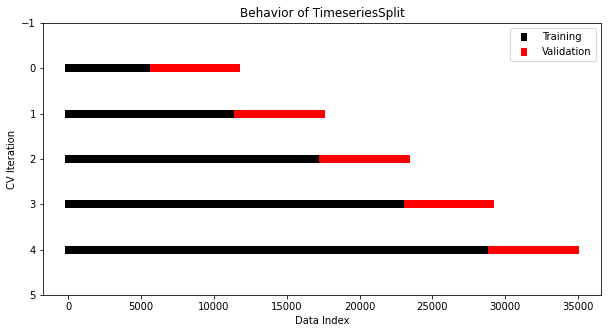

In [38]:
ts_cv = TimeSeriesSplit(n_splits=5)

fig, ax = plt.subplots(figsize=(10, 5))

for ii, (tr, tt) in enumerate(ts_cv.split(X, y)):
    
    p1 = ax.scatter(tr, [ii] * len(tr), c='black', marker="_", lw=8)
    p2 = ax.scatter(tt, [ii] * len(tt), c='red', marker="_", lw=8)
    ax.set(
        title="Behavior of TimeseriesSplit",
        xlabel="Data Index",
        ylabel="CV Iteration",
        ylim=[5, -1],
    )
    ax.legend([p1, p2], ["Training", "Validation"])


plt.show()

def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii ] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    # ax.scatter(
    #     range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    # )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class"]
    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_validate
import numpy as np

# Init RF and CV
rf = RandomForestRegressor(n_estimators=1000, random_state=1121218)

scores = cross_validate(
    rf, X, y, cv=ts_cv, scoring="neg_mean_squared_log_error", return_train_score=True
)

# Base RMSLE
base_rmsle = np.sqrt(-np.mean(scores["test_score"]))
print("Base Root Meat Squared Log Error is: {:.5f}".format(base_rmsle))

C:\Users\elmha\anaconda3\envs\se_venv\lib\site-packages\sklearn\ensemble\base.py:157: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
C:\Users\elmha\anaconda3\envs\se_venv\lib\site-packages\sklearn\ensemble\base.py:157: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check 

Base Root Meat Squared Log Error is: 0.26842


**Base Root Meat Squared Log Error is: 0.26842**

In [1]:
X["Day of the Month"] = X.index.day
X["Day of the Week"] = X.index.weekday
X["Hour of the Day"] = X.index.hour

scores = cross_validate(
    rf, X, y, cv=ts_cv, scoring="neg_mean_squared_log_error", return_train_score=True
)



NameError: name 'X' is not defined

In [ ]:
# Validar ploteo de cv_indices
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

**New RMSLE: 0.26835**

# AUTOMATED ML

In [ ]:
import autosklearn.classification

ModuleNotFoundError: No module named 'autosklearn'

In [ ]:
automl = autosklearn.classification.AutoSklearnClassifier()
automl.fit(X_train, Y_train)
y_hat = automl.predict(X_test)
print("Accuracy score", sklearn.metrics.accuracy_score(Y_test, y_hat))

Accuracy score 0.8377835199540626


In [ ]:
predictions = cls.predict(X_test)
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, predictions))

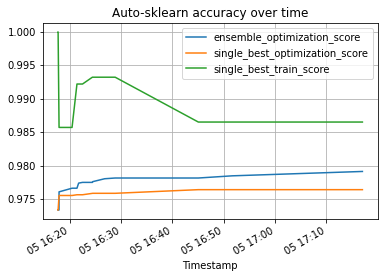

In [ ]:
poT = automl.performance_over_time_
poT.plot(
    x='Timestamp',
    kind='line',
    legend=True,
    title='Auto-sklearn accuracy over time',
    grid=True,
)
plt.show()

In [ ]:
automl.sprint_statistics()
automl.show_models()

"[(0.460000, SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'adaboost', 'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'feature_agglomeration', 'classifier:adaboost:algorithm': 'SAMME', 'classifier:adaboost:learning_rate': 0.9772078202526538, 'classifier:adaboost:max_depth': 5, 'classifier:adaboost:n_estimators': 418, 'data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessor:feature_type:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'median', 'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'quantile_transformer', 'feature_preprocessor:feature_agglomeration:affinity': 'cosine', 'feature_preprocessor:feature_agglomeration:linkage': 'complete', 'feature_preprocessor:feature_agglomeration:n_clusters': 168, 'feature

In [ ]:
automl.get_models_with_weights()

[(0.46,
  SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'adaboost', 'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'feature_agglomeration', 'classifier:adaboost:algorithm': 'SAMME', 'classifier:adaboost:learning_rate': 0.9772078202526538, 'classifier:adaboost:max_depth': 5, 'classifier:adaboost:n_estimators': 418, 'data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessor:feature_type:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'median', 'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'quantile_transformer', 'feature_preprocessor:feature_agglomeration:affinity': 'cosine', 'feature_preprocessor:feature_agglomeration:linkage': 'complete', 'feature_preprocessor:feature_agglomeration:n_clusters': 168, 'feature_pr

In [ ]:
automl.cv_results_.keys()

dict_keys(['mean_test_score', 'mean_fit_time', 'params', 'rank_test_scores', 'status', 'budgets', 'param_balancing:strategy', 'param_classifier:__choice__', 'param_data_preprocessor:__choice__', 'param_feature_preprocessor:__choice__', 'param_classifier:adaboost:algorithm', 'param_classifier:adaboost:learning_rate', 'param_classifier:adaboost:max_depth', 'param_classifier:adaboost:n_estimators', 'param_classifier:bernoulli_nb:alpha', 'param_classifier:bernoulli_nb:fit_prior', 'param_classifier:decision_tree:criterion', 'param_classifier:decision_tree:max_depth_factor', 'param_classifier:decision_tree:max_features', 'param_classifier:decision_tree:max_leaf_nodes', 'param_classifier:decision_tree:min_impurity_decrease', 'param_classifier:decision_tree:min_samples_leaf', 'param_classifier:decision_tree:min_samples_split', 'param_classifier:decision_tree:min_weight_fraction_leaf', 'param_classifier:extra_trees:bootstrap', 'param_classifier:extra_trees:criterion', 'param_classifier:extra_tr

In [ ]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

NameError: name 'train' is not defined

In [ ]:
X.values

array([[ 981.5 ,   17.81,  257.  ],
       [ 871.1 ,   17.86,    9.  ],
       [ 870.7 ,   17.8 ,    9.  ],
       ...,
       [1034.2 ,   22.66,    0.  ],
       [1034.6 ,   22.51,    0.  ],
       [1035.  ,   24.23,    0.  ]])

<AxesSubplot:xlabel='Date_Time'>

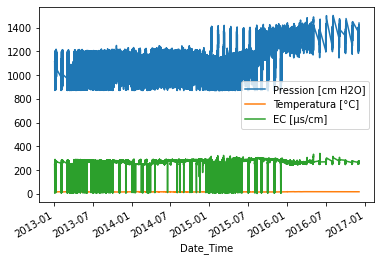

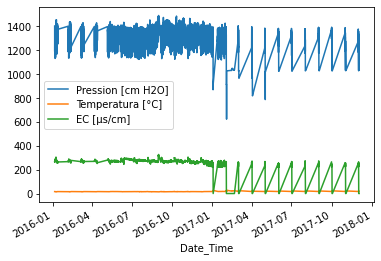

In [ ]:
X_train.plot()

In [ ]:
X_train.tail()
# X_test.head()

,Pression [cm H2O],Temperatura [°C],EC [µs/cm]
Date_Time,,,
2016-06-05 01:00:00-04:00,1391.3,16.71,272
2016-06-05 02:00:00-04:00,1390.7,16.69,271
2016-06-05 03:00:00-04:00,1381.2,16.66,269
2016-06-05 04:00:00-04:00,1299.3,16.63,268
2016-06-05 05:00:00-04:00,1371.4,16.64,268


In [ ]:
X_test.head()

,Pression [cm H2O],Temperatura [°C],EC [µs/cm]
Date_Time,,,
2016-06-05 06:00:00-04:00,1386.8,16.64,268
2016-06-05 07:00:00-04:00,1325.1,16.56,263
2016-06-05 08:00:00-04:00,1344.6,16.61,266
2016-06-05 09:00:00-04:00,1364.0,16.66,269
2016-06-05 10:00:00-04:00,1273.0,16.66,268


In [ ]:
y_train.head()

Date_Time
2013-02-03 10:00:00-03:00    1
2013-02-03 11:00:00-03:00    1
2013-02-03 12:00:00-03:00    1
2013-02-03 13:00:00-03:00    1
2013-02-03 14:00:00-03:00    1
Name: etiqueta conjunta, dtype: int64

In [ ]:
clf = IsolationForest(random_state=0,contamination=0.1).fit(X_train)

out=clf.predict(X_test)

In [ ]:
new_df = pd.DataFrame()
8
new_df['real'] = y_test
new_df['predicted'] = out

In [ ]:
new_df.replace(to_replace=-1,value=0,inplace=True)

In [ ]:
print(sklearn.metrics.classification_report(new_df['real'].values,new_df['predicted'].values))

              precision    recall  f1-score   support

           0       0.62      0.31      0.42      5313
           1       0.15      0.39      0.22      1653

    accuracy                           0.33      6966
   macro avg       0.39      0.35      0.32      6966
weighted avg       0.51      0.33      0.37      6966



In [ ]:
new_df[new_df['real']==1]


,real,predicted
Date_Time,,
2016-03-05 21:00:00-03:00,1,0
2016-03-05 22:00:00-03:00,1,1
2016-03-05 23:00:00-03:00,1,1
2016-03-06 00:00:00-03:00,1,1
2016-03-06 01:00:00-03:00,1,1
...,...,...
2017-02-20 08:00:00-03:00,1,0
2017-02-20 09:00:00-03:00,1,0
2017-02-20 10:00:00-03:00,1,0


In [ ]:
clf.get_params()

{'behaviour': 'deprecated',
 'bootstrap': False,
 'contamination': 0.1,
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [ ]:
print(X_train.shape)
print(X_test.shape)

(27861, 3)
(6966, 3)


<AxesSubplot:xlabel='Date_Time'>

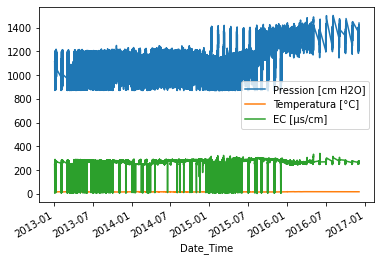

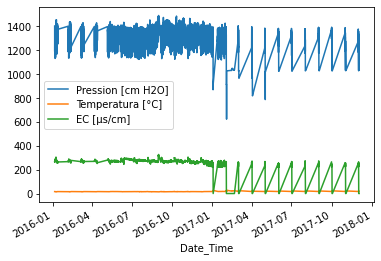

In [ ]:
X_train.plot()
X_test.plot()

In [ ]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [ ]:
# Some useful parameters which will come in handy later on
ntrain = X_train.shape[0]
ntest = X_test.shape[0]

SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS, random_state=SEED)
    # KFold()
# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

In [ ]:
enumerate(kf)

TypeError: 'KFold' object is not iterable

In [ ]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [ ]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [ ]:
y_train.values

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [ ]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [ ]:
x_train = X_train.values
x_test = X_test.values

y_train = Y_train.values
y_test = Y_test.values

In [ ]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

In [ ]:
print('Training is complete')

In [ ]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

<function sklearn.model_selection._split._BaseKFold.get_n_splits(self, X=None, y=None, groups=None)>